In [19]:
!pip -q install scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ---------------------------
# 1) Data (small subset for speed)
# ---------------------------
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

n_train_small = 20000
n_test_small  = 8000

train_small = Subset(train_dataset, list(range(n_train_small)))
test_small  = Subset(test_dataset,  list(range(n_test_small)))

batch_size = 128
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_small,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ---------------------------
# 2) Patch extraction
# ---------------------------
patch_size = 4

def extract_patches_batch(x, patch_size=patch_size):
    """
    x: (B,3,32,32)
    returns:
      patches_flat: (B*P, D) where D=3*ps*ps, P=(32/ps)^2
      n_h, n_w
    """
    B, C, H, W = x.shape
    ps = patch_size
    assert H % ps == 0 and W % ps == 0
    n_h, n_w = H // ps, W // ps

    # (B,C,n_h,ps,n_w,ps)
    patches = x.unfold(2, ps, ps).unfold(3, ps, ps)
    # -> (B,n_h,n_w,C,ps,ps)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches_flat = patches.view(B * n_h * n_w, C * ps * ps)
    return patches_flat, n_h, n_w

def rebuild_from_patches(patches_flat, n_h, n_w, patch_size=patch_size):
    """
    patches_flat: (B*P, D)
    returns x: (B,3,32,32)
    """
    ps = patch_size
    D = 3 * ps * ps
    assert patches_flat.shape[1] == D
    P = n_h * n_w
    B = patches_flat.shape[0] // P

    patches = patches_flat.view(B, n_h, n_w, 3, ps, ps)
    # -> (B,3,n_h,ps,n_w,ps)
    patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
    x = patches.view(B, 3, n_h * ps, n_w * ps)
    return x

# ---------------------------
# 3) PCA encode/decode (patch-wise)
# ---------------------------
def pca_encode_patches(x, pca):
    """
    x: (B,3,32,32)
    returns z: (B,P,latent_dim), plus n_h,n_w
    """
    patches, n_h, n_w = extract_patches_batch(x)
    z_np = pca.transform(patches.cpu().numpy())  # (B*P, latent_dim)
    z = torch.from_numpy(z_np).float().to(device)
    B = x.size(0)
    P = n_h * n_w
    z = z.view(B, P, -1)
    return z, n_h, n_w

def pca_decode_patches(z, n_h, n_w, pca):
    """
    z: (B,P,latent_dim)
    returns x: (B,3,32,32)
    """
    B, P, ld = z.shape
    z_np = z.detach().cpu().numpy().reshape(B * P, ld)
    patches_np = pca.inverse_transform(z_np)  # (B*P, D)
    patches = torch.from_numpy(patches_np).float().to(device)
    x = rebuild_from_patches(patches, n_h, n_w)
    x = x.clamp(0.0, 1.0)
    return x

# ---------------------------
# 4) Small conv denoising autoencoder
# ---------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,   64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 64x16x16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 128x8x8
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 256x4x4
        )

    def forward(self, x):
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128,  64, kernel_size=2, stride=2),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d( 64,   3, kernel_size=2, stride=2),  # 32x32
            nn.Sigmoid(),
        )

    def forward(self, h):
        return self.deconv(h)

class PCA_LDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x_noisy):
        h = self.encoder(x_noisy)
        x_rec = self.decoder(h)
        return x_rec, h

# ---------------------------
# 5) Linear probe
# ---------------------------
class LinearClassifier(nn.Module):
    def __init__(self, in_dim=256, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def extract_features(model, dataloader):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            _, h = model(x)                # (B,256,4,4)
            h_pool = h.mean(dim=(2,3))     # (B,256)
            feats.append(h_pool.cpu())
            labels.append(y)
    return torch.cat(feats, dim=0), torch.cat(labels, dim=0)

def train_linear_probe(train_feats, train_labels, test_feats, test_labels, epochs=10, lr=1e-3):
    clf = LinearClassifier(in_dim=train_feats.size(1), num_classes=10).to(device)
    opt = optim.Adam(clf.parameters(), lr=lr)
    ce  = nn.CrossEntropyLoss()

    train_ds = TensorDataset(train_feats, train_labels)
    test_ds  = TensorDataset(test_feats,  test_labels)
    train_lp = DataLoader(train_ds, batch_size=256, shuffle=True)
    test_lp  = DataLoader(test_ds,  batch_size=256, shuffle=False)

    for ep in range(epochs):
        clf.train()
        for f, y in train_lp:
            f, y = f.to(device), y.to(device)
            opt.zero_grad()
            loss = ce(clf(f), y)
            loss.backward()
            opt.step()

    clf.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for f, y in test_lp:
            f, y = f.to(device), y.to(device)
            pred = clf(f).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

# ---------------------------
# 6) loop: latent_dim = 8,16,32
# ---------------------------
latent_dims = [8, 16, 32]

n_pca_samples = 5000     # how many images to fit PCA on (fast)
epochs_ae      = 10      # few epochs, trend-only
epochs_lp      = 15     # linear probe epochs
T         = 10
sigma_min = 0.0
sigma_max = float(np.sqrt(2.0))

results = []

for latent_dim in latent_dims:
    print("\n==============================")
    print("latent_dim =", latent_dim)

    # --- fit PCA on patches from first n_pca_samples images ---
    pca_subset = Subset(train_dataset, list(range(n_pca_samples)))
    pca_loader = DataLoader(pca_subset, batch_size=256, shuffle=False, num_workers=2)

    patches_list = []
    for x, _ in pca_loader:
        p_flat, _, _ = extract_patches_batch(x)
        patches_list.append(p_flat.numpy())
    X_patches = np.concatenate(patches_list, axis=0)
    print("PCA patches:", X_patches.shape)

    pca = PCA(n_components=latent_dim, svd_solver="randomized")
    pca.fit(X_patches)
    print("PCA fitted.")

    # --- train AE with latent-noise corruption ---
    model = PCA_LDAE().to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    mse = nn.MSELoss()

    model.train()
    for ep in range(epochs_ae):
        running = 0.0
        for x, _ in train_loader:
            x = x.to(device)

            # PCA encode -> add noise -> PCA decode
            z, n_h, n_w = pca_encode_patches(x, pca)
            B, P, d = z.shape
            t = torch.randint(low=0, high=T, size=(B,), device=device).float()
            sigmas = sigma_min + (sigma_max - sigma_min) * (t / (T - 1))   # (B,)
            sigmas = sigmas.view(B, 1, 1)                                  # (B,1,1)

            eps = torch.randn_like(z)
            z_noisy = z + eps * sigmas
            x_noisy = pca_decode_patches(z_noisy, n_h, n_w, pca)

            opt.zero_grad()
            x_rec, _ = model(x_noisy)
            loss = mse(x_rec, x)
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)

        print(f"[AE epoch {ep+1}/{epochs_ae}] MSE: {running/len(train_small):.6f}")

    # --- linear probe on encoder features ---
    for p in model.encoder.parameters():
        p.requires_grad = False
    model.eval()

    train_feats, train_labels = extract_features(model, train_loader)
    test_feats,  test_labels  = extract_features(model, test_loader)

    acc = train_linear_probe(train_feats, train_labels, test_feats, test_labels, epochs=epochs_lp)
    print(f"Linear probe accuracy (d={latent_dim}): {acc:.2f}%")

    results.append((latent_dim, acc))




device: cuda

latent_dim = 8
PCA patches: (320000, 48)
PCA fitted.
[AE epoch 1/10] MSE: 0.028080
[AE epoch 2/10] MSE: 0.018748
[AE epoch 3/10] MSE: 0.017476
[AE epoch 4/10] MSE: 0.016914
[AE epoch 5/10] MSE: 0.016369
[AE epoch 6/10] MSE: 0.016123
[AE epoch 7/10] MSE: 0.015721
[AE epoch 8/10] MSE: 0.015607
[AE epoch 9/10] MSE: 0.015284
[AE epoch 10/10] MSE: 0.015118
Linear probe accuracy (d=8): 37.84%

latent_dim = 16
PCA patches: (320000, 48)
PCA fitted.
[AE epoch 1/10] MSE: 0.030708
[AE epoch 2/10] MSE: 0.019750
[AE epoch 3/10] MSE: 0.017860
[AE epoch 4/10] MSE: 0.017253
[AE epoch 5/10] MSE: 0.016633
[AE epoch 6/10] MSE: 0.016257
[AE epoch 7/10] MSE: 0.016073
[AE epoch 8/10] MSE: 0.015740
[AE epoch 9/10] MSE: 0.015414
[AE epoch 10/10] MSE: 0.015299
Linear probe accuracy (d=16): 37.48%

latent_dim = 32
PCA patches: (320000, 48)
PCA fitted.
[AE epoch 1/10] MSE: 0.032396
[AE epoch 2/10] MSE: 0.021974
[AE epoch 3/10] MSE: 0.019037
[AE epoch 4/10] MSE: 0.018421
[AE epoch 5/10] MSE: 0.01785


=== SUMMARY ===
d= 8  ->  37.84%
d=16  ->  37.48%
d=32  ->  35.38%


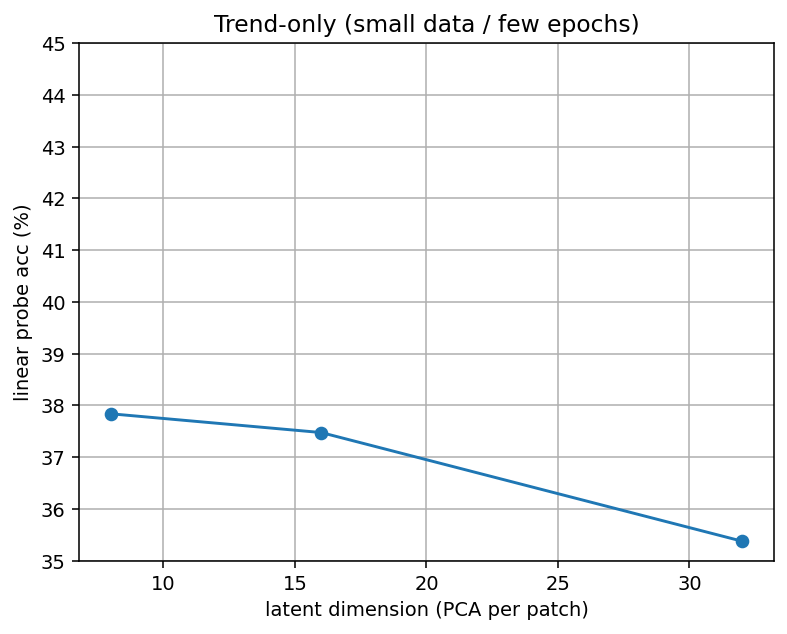

In [20]:
# ---------------------------
# 7) Print + plot results
# ---------------------------
print("\n=== SUMMARY ===")
for d, acc in results:
    print(f"d={d:2d}  ->  {acc:.2f}%")

ds = [d for d,_ in results]
accs = [a for _,a in results]
plt.figure(dpi=140)
plt.plot(ds, accs, marker="o")
plt.xlabel("latent dimension (PCA per patch)")
plt.ylabel("linear probe acc (%)")
plt.title("Trend-only (small data / few epochs)")
plt.grid(True)
plt.ylim(35, 45)
plt.yticks(np.arange(35, 46, 1))
plt.show()
